In [2]:
# Imports
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import dask
from dask.distributed import Client
import dask.bag as db

In [3]:
dtypes = {'buildingblock1_smiles': np.int16, 'buildingblock2_smiles': np.int16, 'buildingblock3_smiles': np.int16,
          'binds_BRD4':np.byte, 'binds_HSA':np.byte, 'binds_sEH':np.byte}

directory = Path("../data/shrunken/")
train = pd.read_parquet(directory / "train.parquet")

In [4]:
BBs_dict_reverse_1 = pickle.load(open(directory / 'train_dicts/BBs_dict_reverse_1.p', 'br'))
BBs_dict_reverse_2 = pickle.load(open(directory / 'train_dicts/BBs_dict_reverse_2.p', 'br'))
BBs_dict_reverse_3 = pickle.load(open(directory / 'train_dicts/BBs_dict_reverse_3.p', 'br'))

In [5]:
client = Client()

In [6]:
# Get 25 descriptors
desc_list = [desc_func for desc_name, desc_func in Descriptors._descList][:18]
desc_names = [desc_name for desc_name, desc_func in Descriptors._descList][:18]

def calculate_single_descriptor(mol, desc):
    return desc(mol)

# Create a function to calculate descriptors
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    desc = [calculate_single_descriptor(mol, desc) for desc in desc_list]
    return desc


In [7]:
# Create train dataset with 25% binds_BRD4 or binds_HSA or binds_sEH and 75% no binds
train_df = train[(train.binds_BRD4 == 1) | (train.binds_HSA == 1) | (train.binds_sEH == 1)].sample(n=2000)
train_df = pd.concat([train_df, train[(train.binds_BRD4 == 0) & (train.binds_HSA == 0) & (train.binds_sEH == 0)].sample(n=8000)])
train_df.reset_index(drop=True, inplace=True)

In [8]:
# Sample from the train dataset 10,000
# train_df = train.sample(n=10000)

In [9]:
b = db.from_sequence(train_df.molecule_smiles)
descriptors = b.map(calculate_descriptors)

In [10]:
descriptors = descriptors.compute()

In [11]:
len(descriptors)

10000

In [12]:
# Create a dataframe
desc_df = pd.DataFrame(descriptors, columns=desc_names)

# Add the target columns
desc_df['binds_BRD4'] = train_df.binds_BRD4
desc_df['binds_HSA'] = train_df.binds_HSA
desc_df['binds_sEH'] = train_df.binds_sEH

In [13]:
print(f"Percentage of rows with at least one binding: {desc_df[(desc_df.binds_BRD4 == 1) | (desc_df.binds_HSA == 1) | (desc_df.binds_sEH == 1)].shape[0] / desc_df.shape[0] * 100:.2f}%")

Percentage of rows with at least one binding: 20.00%


In [14]:
# Number of rows with at least one binding
desc_df[(desc_df.binds_BRD4 == 1) | (desc_df.binds_HSA == 1) | (desc_df.binds_sEH == 1)].shape[0]

2000

In [15]:
# Replace NaN values with 0
desc_df.fillna(0, inplace=True)

# Replace inf values with 0
desc_df.replace([np.inf, -np.inf], 0, inplace=True)

In [16]:
# Train unsupervised model to cluster the data and colour the molecules based on what protein they bind to
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create a KMeans model
kmeans = KMeans(n_clusters=4, random_state=42, verbose=1)
kmeans.fit(desc_df.iloc[:, :-3])

# Create a TSNE model
tsne = TSNE(n_components=2, random_state=42, verbose=1)
tsne_df = tsne.fit_transform(desc_df.iloc[:, :-3])

Initialization complete
Iteration 0, inertia 28323529.824632917.
Iteration 1, inertia 24402498.41690492.
Iteration 2, inertia 24101312.187400535.
Iteration 3, inertia 24002054.33569596.
Iteration 4, inertia 23964086.308937106.
Iteration 5, inertia 23955054.119192503.
Iteration 6, inertia 23950825.508161478.
Iteration 7, inertia 23946847.863433.
Iteration 8, inertia 23943738.531947117.
Iteration 9, inertia 23941331.644945092.
Iteration 10, inertia 23940368.6581993.
Iteration 11, inertia 23939728.241206404.
Iteration 12, inertia 23939129.248214018.
Converged at iteration 12: center shift 0.03943538731438555 within tolerance 0.08656361270220499.
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.361s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SN

/tmp/ipykernel_27659/3229092776.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = desc_df[['binds_BRD4', 'binds_HSA', 'binds_sEH']].apply(lambda x: x[0] + 2*x[1] + 3*x[2], axis=1).to_list()
/tmp/ipykernel_27659/3229092776.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_df[:, 0], tsne_df[:, 1], cmap=cmap, s=sizes, alpha=0.2)


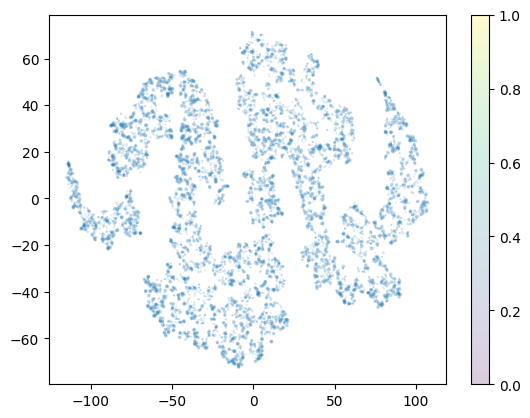

In [19]:
# Create a colormap where its see through for 0, red for 1, green for 2, blue for 3, black for 4 and white for 5
cmap = ListedColormap(['#000000', '#FF0000', '#00FF00', '#0000FF', '#000000', '#FFFFF0'])

# Plot with labels: Labels = (0,0,0) = 0, (1,0,0) = 1, (0,1,0) = 2, (0,0,1) = 3 
labels = desc_df[['binds_BRD4', 'binds_HSA', 'binds_sEH']].apply(lambda x: x[0] + 2*x[1] + 3*x[2], axis=1).to_list() 
# If labels = 0, size is 0.1
sizes = [0.1 if x == 0 else 3 for x in labels]

# Scatter with small dots, if labels are larger than 0, the dots will be bigger
plt.scatter(tsne_df[:, 0], tsne_df[:, 1], cmap=cmap, s=sizes, alpha=0.2)
plt.colorbar()
plt.show()